In [351]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

import warnings
#warnings.filterwarnings('ignore')
pd.set_option("future.no_silent_downcasting", True)

seed = 1234
np.random.seed(seed)  

In [352]:
columns = ["age", "workclass", "fnlwgt", "education", "education_num", "marital_status",
           "occupation", "relationship", "race", "sex", "capital_gain", "capital_loss",
           "hours_per_week", "native_country", "income"]

# Read train data and treat " ?" as Null values
train_df = pd.read_csv("adult/adult.data", names=columns, sep=",", header=None, na_values=[" ?"])

# test data and treat " ?" as Null values
test_df = pd.read_csv("adult/adult.test", names=columns, sep=",", header=None, skiprows=1, na_values=[" ?"])

In [354]:
print(train_df.shape)
train_df.head()

(32561, 15)


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [356]:
# print(test_df.shape)
# test_df.head()

In [359]:
# train_df.info();

In [361]:
# Summary statistics for numerical columns
# print(train_df.describe());

### preprocessing

In [364]:
# number of missing values in train data
print(train_df.isnull().sum())  

# drop null rows
train_df.dropna(inplace=True)

# number of values in train data after dropping rows
#print(train_df.isnull().sum())  

age                  0
workclass         1836
fnlwgt               0
education            0
education_num        0
marital_status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital_gain         0
capital_loss         0
hours_per_week       0
native_country     583
income               0
dtype: int64


In [366]:
# number of missing values in test data
print(test_df.isnull().sum())  

# drop null rows
test_df.dropna(inplace=True)

# number of missing values in test data after dropping rows
#print(test_df.isnull().sum())  

age                 0
workclass         963
fnlwgt              0
education           0
education_num       0
marital_status      0
occupation        966
relationship        0
race                0
sex                 0
capital_gain        0
capital_loss        0
hours_per_week      0
native_country    274
income              0
dtype: int64


In [368]:
# remove any whitespace 
train_df = train_df.apply(lambda col: col.str.strip() if col.dtype == 'object' else col)

# binary mapping for target labels
train_df['income'] = train_df['income'].map({'<=50K': 0, '>50K': 1})


In [370]:
# remove any whitespace 
test_df = test_df.apply(lambda col: col.str.strip() if col.dtype == 'object' else col)

# target labels of adult.test end with ".", we remove "."
test_df['income'] = test_df['income'].str.strip().str.replace('.', '')

# binary mapping for target labels
test_df['income'] = test_df['income'].map({'<=50K': 0, '>50K': 1})


In [372]:
#The education column and education_num column essentially provide 
# the same information about a person’s education level. 
# education_num is just a numerical encoding of the education column,
# preserving the ordinal nature of education levels. 
# keeping both columns might create unnecessary redundancy in the dataset.

# since the education_num col is derived from education col, 
# they are highly correlated correlated features which
# can lead to multicollinearity and negatively affect the model's performance

# drop the education col
train_df = train_df.drop(columns=['education'])
test_df = test_df.drop(columns=['education'])

## EDA

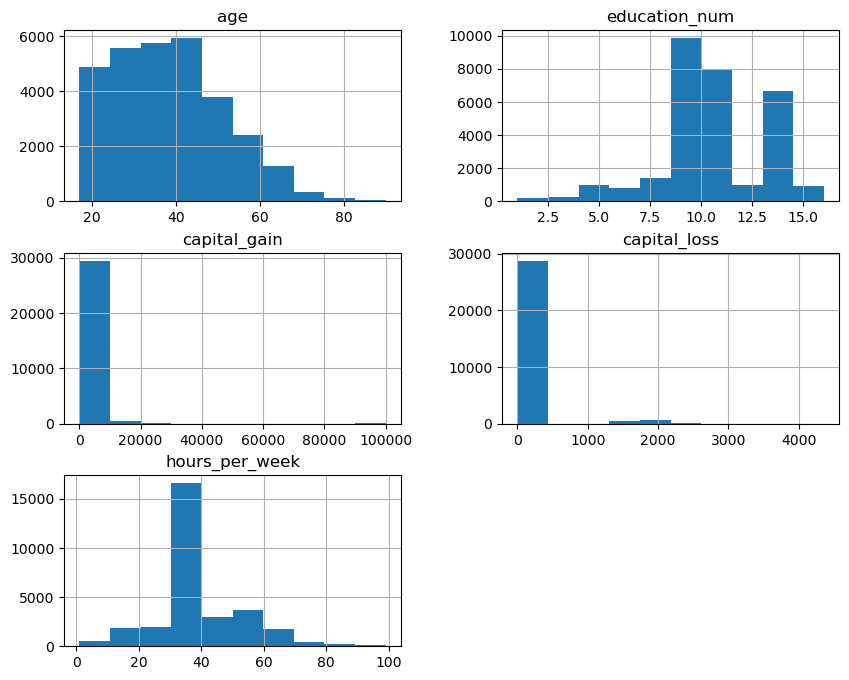

In [375]:
# Histogram
numerical_features = ['age', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']
train_df[numerical_features].hist(figsize=(10, 8));

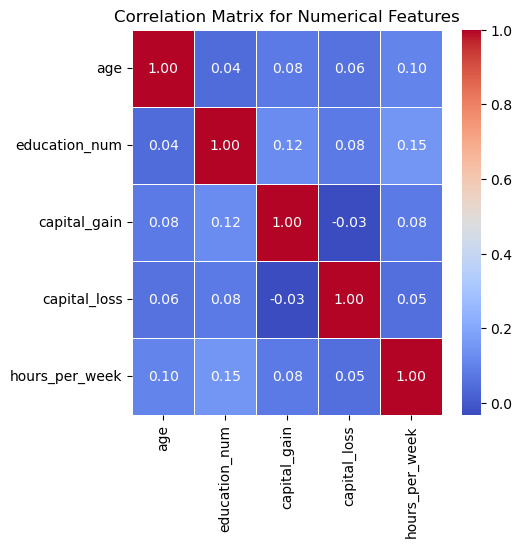

In [376]:
# CORRELATION MATRIX /HEATMAP
numerical_features = ['age', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']

#  correlation matrix
correlation_matrix = train_df[numerical_features].corr()

plt.figure(figsize=(5, 5))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix for Numerical Features")
plt.show()

In [377]:
# ANALYSIS ????

### Splitting train_df into train & validation sets

In [380]:
# Features
X = train_df.drop(columns=["income"])
# Target labels
y = train_df["income"]  

X_train, X_val, y_train, y_val  = train_test_split(X, y, test_size=0.1, random_state=seed, shuffle=True)

train_df

,age,workclass,fnlwgt,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,0
32557,40,Private,154374,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,1
32558,58,Private,151910,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,0
32559,22,Private,201490,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,0


In [384]:
print(X.shape)
print(X_train.shape)
print(X_val.shape)

(30162, 13)
(27145, 13)
(3017, 13)


In [386]:
X_test = test_df.drop(columns=['income'])
y_test = test_df['income']

test_df

,age,workclass,fnlwgt,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,25,Private,226802,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,0
1,38,Private,89814,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,0
2,28,Local-gov,336951,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,1
3,44,Private,160323,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,1
5,34,Private,198693,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16275,33,Private,245211,13,Never-married,Prof-specialty,Own-child,White,Male,0,0,40,United-States,0
16276,39,Private,215419,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States,0
16278,38,Private,374983,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,0
16279,44,Private,83891,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,0


### converting categorical data to numerical values (Encoding)

In [389]:
#label encoder
# https://medium.com/@kattilaxman4/a-practical-guide-for-python-label-encoding-with-python-fb0b0e7079c5
# one hot encoder 
#https://www.geeksforgeeks.org/ml-one-hot-encoding/

categorical_nominal_features =[ 'workclass',  'marital_status', 'occupation',
                        'relationship', 'race', 'sex',  'native_country']

# code for pd dummies 
X_train = pd.get_dummies(X_train, columns=categorical_nominal_features)
X_val = pd.get_dummies(X_val, columns=categorical_nominal_features)
X_test = pd.get_dummies(X_test, columns=categorical_nominal_features)

X_train, X_val = X_train.align(X_val, join='left', axis=1)
X_train, X_test = X_train.align(X_test, join='left', axis=1)

# label_encoder = LabelEncoder()
    
# print(X_train['education'].unique())
# X_train['education']= label_encoder.fit_transform(X_train['education'])
# print(X_train['education'].unique())
    
# X_val['education'] = label_encoder.transform(X_val['education'])
# X_test['education']= label_encoder.transform(X_test['education'])


## code for label encoder
# for feature in categorical_features: 
#     print("\n", feature)
#     label_encoder = LabelEncoder()
    
#     print(X_train[feature].unique())
#     X_train[feature]= label_encoder.fit_transform(X_train[feature])
#     print(X_train[feature].unique())
    
#     X_val[feature] = label_encoder.transform(X_val[feature])
#     X_test[feature]= label_encoder.transform(X_test[feature])

# # encoding target labels 
# label_encoder = LabelEncoder()
# # Fit the encoder on the target variable
# y_train = label_encoder.fit_transform(y_train)  # Training target variable
# y_val = label_encoder.transform(y_val)          # Validation target variable
# y_test= label_encoder.transform(y_test)        # Test target variable

In [391]:
print(X.shape)
print(X_train.shape)
print(X_val.shape)

#X_train

(30162, 13)
(27145, 88)
(3017, 88)


### Feature scaling

In [394]:
# NO FEAUTURE SCALING REQUIRED FOR TREE BASED MODELS
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


## Random Forest

In [397]:
# BASE model

# learner with default params
learner = RandomForestClassifier(random_state=seed)
learner.fit(X_train, y_train)

#  training  error rate
train_err = (y_train!= learner.predict(X_train)).mean()
print(f"\nTraining error rate : ", train_err)

# validation error rate
val_err = (y_val!= learner.predict(X_val)).mean()
print(f"\nvalidation error rate : ", val_err)

# test error rate
test_err = (y_test!= learner.predict(X_test)).mean()
print(f"\ntest error rate : ", test_err)


Training error rate :  0.00014735678762202984

validation error rate :  0.13854822671528008

test error rate :  0.15099601593625497


In [398]:
learner?

Type:        RandomForestClassifier
String form: RandomForestClassifier(random_state=1234)
Length:      100
File:        /opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_forest.py
Docstring:  
A random forest classifier.

A random forest is a meta estimator that fits a number of decision tree
classifiers on various sub-samples of the dataset and uses averaging to
improve the predictive accuracy and control over-fitting.
Trees in the forest use the best split strategy, i.e. equivalent to passing
`splitter="best"` to the underlying :class:`~sklearn.tree.DecisionTreeRegressor`.
The sub-sample size is controlled with the `max_samples` parameter if
`bootstrap=True` (default), otherwise the whole dataset is used to build
each tree.

For a comparison between tree-based ensemble models see the example
:ref:`sphx_glr_auto_examples_ensemble_plot_forest_hist_grad_boosting_comparison.py`.

Read more in the :ref:`User Guide <forest>`.

Parameters
----------
n_estimators : int, default=

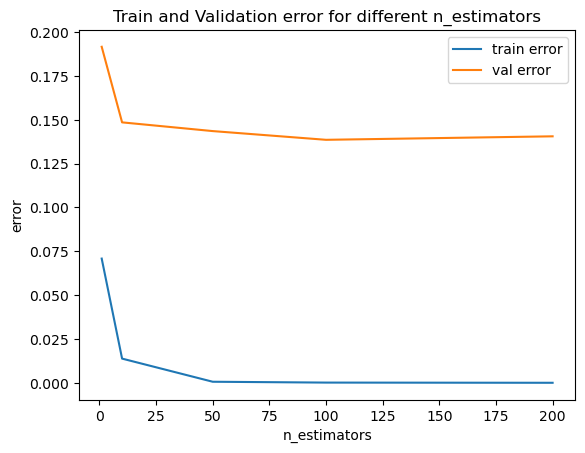

In [403]:
# number of trees to use in the ensemble
n_estimators = [1, 10, 50, 100,200]

train_errors = []
val_errors = []

for n in n_estimators: 

     RF = RandomForestClassifier( 
                     n_estimators=n, # number of trees
                     #max_depth=10,  # Restrict depth
                     #min_samples_split=5,  # Minimum samples required to split
                     random_state=seed)

     RF.fit(X_train, y_train)

     # Compute the training  error rates
     train_err = (y_train!= RF.predict(X_train)).mean()
     train_errors.append(train_err)

     # Compute the validation error rates
     val_err = (y_val!= RF.predict(X_val)).mean()
     val_errors.append(val_err)

# Plot the resulting performance as a function of n estimate, bootstrap
plt.plot(n_estimators , train_errors,  label = 'train error');
plt.plot(n_estimators , val_errors,    label = 'val error');

plt.xlabel('n_estimators')
plt.ylabel('error')
plt.title('Train and Validation error for different n_estimators')
plt.legend()
plt.show()

In [84]:
# We can see that the fit of the random forest models (given multiple ensemble members) a single tree

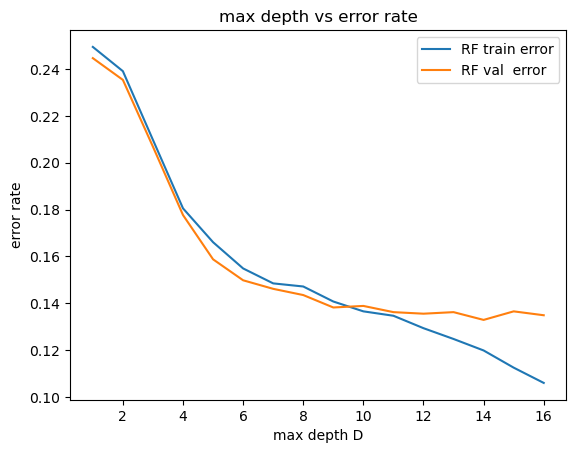

In [405]:
RF_train_err_d = []
RF_val_err_d = []

depth = list(range(1, 17))

for d in depth:
    learner = RandomForestClassifier(
    max_depth=d,  # Restrict depth
    random_state=seed
)
    learner.fit(X_train,y_train);

    # Compute the training  error rates
    train_err = (y_train!= learner.predict(X_train)).mean()
    RF_train_err_d.append(train_err)

    # Compute the validation error rates
    val_err = (y_val!= learner.predict(X_val)).mean()
    RF_val_err_d.append(val_err)

# Plot the resulting performance as a function of depth d
plt.plot(depth , RF_train_err_d,  label = 'RF train error');
plt.plot(depth , RF_val_err_d,    label = 'RF val  error');

plt.title("max depth vs error rate");
plt.xlabel("max depth D");
plt.ylabel("error rate");
plt.legend();

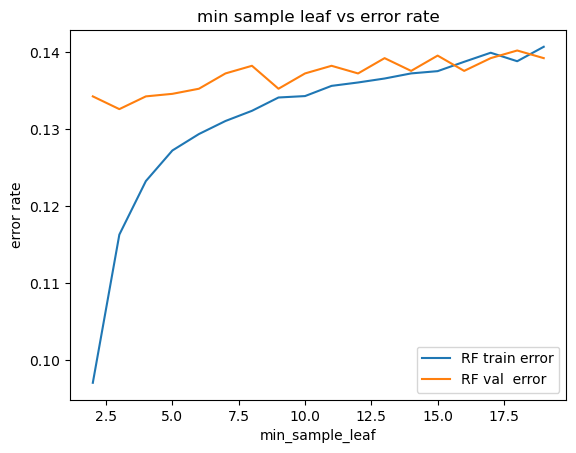

In [407]:
RF_train_err_msl = []
RF_val_err_msl = []
min_sample_leaf =  list(range(2, 20))

# creating values
# for i in range(1,6): 
#     min_sample_leaf.append(2**i)
    
for msl in min_sample_leaf: 
    
    learner = RandomForestClassifier(
    #max_depth=10,  # Restrict depth
    min_samples_leaf=msl,  
    random_state=seed)
    
    learner.fit(X_train,y_train);

    # Compute the training  error rates
    train_err = (y_train!= learner.predict(X_train)).mean()
    RF_train_err_msl.append(train_err)

    # Compute the validation error rates
    val_err = (y_val!= learner.predict(X_val)).mean()
    RF_val_err_msl.append(val_err)

# Plot the resulting performance as a function of min sample leaf
plt.plot(min_sample_leaf , RF_train_err_msl,  label = 'RF train error');
plt.plot(min_sample_leaf , RF_val_err_msl,    label = 'RF val  error');
#plt.xscale('log', base=2)

plt.title("min sample leaf vs error rate");
plt.xlabel("min_sample_leaf");
plt.ylabel("error rate");
plt.legend();

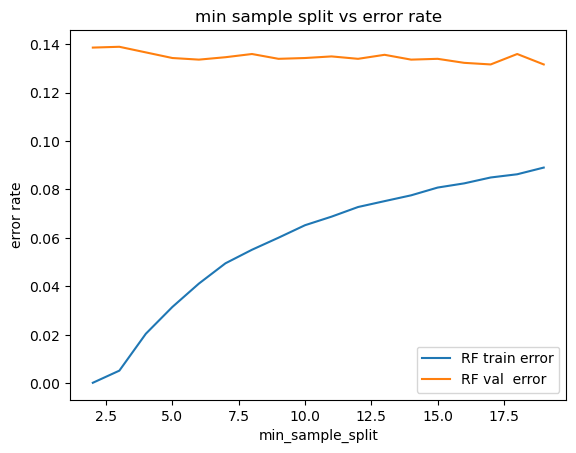

In [411]:
RF_train_err_mss = []
RF_val_err_mss = []
min_sample_split =  list(range(2, 20))
    
for mss in min_sample_split: 
    
    learner = RandomForestClassifier(
    #max_depth=10,  # Restrict depth
    min_samples_split=mss,  
    random_state=seed)
    
    learner.fit(X_train,y_train);

    # Compute the training  error rates
    train_err = (y_train!= learner.predict(X_train)).mean()
    RF_train_err_mss.append(train_err)

    # Compute the validation error rates
    val_err = (y_val!= learner.predict(X_val)).mean()
    RF_val_err_mss.append(val_err)

# Plot the resulting performance as a function of min sample leaf
plt.plot(min_sample_split , RF_train_err_mss,  label = 'RF train error');
plt.plot(min_sample_split , RF_val_err_mss,    label = 'RF val  error');
#plt.xscale('log', base=2)

plt.title("min sample split vs error rate");
plt.xlabel("min_sample_split");
plt.ylabel("error rate");
plt.legend();

In [431]:
train_err = []
val_err = []

max_f =  ['sqrt', 'log2', 0.25, 0.5, 0.75]

    
for mf in max_f:
    learner = RandomForestClassifier(
    max_features=mf,   
    random_state=seed)
    
    learner.fit(X_train,y_train);

    # Compute the training  error rates
    train_err = (y_train!= learner.predict(X_train)).mean()
    print("train err for ", mf, " ", train_err)

    # Compute the validation error rates
    val_err = (y_val!= learner.predict(X_val)).mean()
    print("val err for ", mf, " ", val_err)

# # Plot the resulting performance as a function of min sample leaf
# plt.plot(max_f , train_err,  label = 'RF train error');
# plt.plot( max_f , val_err,    label = 'RF val  error');
# #plt.xscale('log', base=2)

# plt.title("min sample split vs error rate");
# plt.xlabel("min_sample_split");
# plt.ylabel("error rate");
# plt.legend();

train err for  sqrt   0.00014735678762202984
val err for  sqrt   0.13854822671528008
train err for  log2   0.00011051759071652238
val err for  log2   0.14385150812064965
train err for  0.25   0.00014735678762202984
val err for  0.25   0.13722240636393768
train err for  0.5   0.0001841959845275373
val err for  0.5   0.13821677162744447
train err for  0.75   0.00014735678762202984
val err for  0.75   0.13622804110043088


In [441]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')

# param_grid = {
#     'n_estimators': [100,200],
#     'max_depth': [7,10,14],
#     'min_samples_split': [6,9],
#     'min_samples_leaf': [5,10,12]
# }

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, 15, None],
    'max_features': ['sqrt', 'log2', 0.5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
}
# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')
# grid_search.fit(X_train, y_train)

# print("Best parameters:", grid_search.best_params_)
# print("Best score:", grid_search.best_score_)

random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(),
    param_distributions=param_grid,
    n_iter=50,  # Number of parameter settings sampled
    cv=3,       # Number of cross-validation folds
    random_state=42,
    n_jobs=-1   # Use all available cores
)
random_search.fit(X_train, y_train)



RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'max_depth': [5, 10, 15, None],
                                        'max_features': ['sqrt', 'log2', 0.5],
                                        'min_samples_leaf': [1, 2, 5],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200]},
                   random_state=42)

In [446]:
print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)

Best parameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 0.5, 'max_depth': 15}
Best score: 0.8603058300948332


## optimal model

In [470]:
# learner with tuned hyperparameters (from graphs)
#learner = RandomForestClassifier(random_state=seed, max_depth= 14, min_samples_leaf=12, min_samples_split = 6, n_estimators = 200, max_features=0.75)

# learner with random grid search result
learner = RandomForestClassifier(random_state=seed, max_depth= 15, min_samples_leaf=1, min_samples_split = 5, n_estimators = 100 ,max_features=0.5)

learner = RandomForestClassifier(random_state=seed, max_depth= 15, n_estimators = 200 ,max_features=0.5)
learner.fit(X_train, y_train)

#  training  error rate
train_err = (y_train!= learner.predict(X_train)).mean()
print(f"\nTraining error rate : ", train_err)

# validation error rate
val_err = (y_val!= learner.predict(X_val)).mean()
print(f"\nvalidation error rate : ", val_err)

# test error rate
test_err = (y_test!= learner.predict(X_test)).mean()
print(f"\ntest error rate : ", test_err)


Training error rate :  0.08922453490513907

validation error rate :  0.12694729864103413

test error rate :  0.13811420982735723


## Cross Validation

In [ ]:
# perform cross val

## Gradient Boost

In [265]:
# https://medium.com/@24littledino/xgboost-classification-in-python-f29cc2c50a9b
import xgboost as xgb

# Initialize the XGBoost model (this is the sklearn-compatible API)
model = xgb.XGBClassifier(
    objective='binary:logistic',  # For binary classification
    eval_metric='logloss',        # Evaluation metric
    use_label_encoder=False,      # Avoid label encoder warning
    random_state=seed               # For reproducibility
)

# Fit the model to the training data
model.fit(X_train, y_train)

# Compute the training  error rates
train_err = (y_train!= model.predict(X_train)).mean()
print(f"\nTraining error rate : ", train_err)

# Compute the validation error rates
val_err = (y_val!= model.predict(X_val)).mean()
print(f"\nvalidation error rate : ", val_err)

# Compute the tes error rates
test_err = (y_test!= model.predict(X_test)).mean()
print(f"\ntest error rate : ", test_err)


Training error rate :  0.10057100755203537

validation error rate :  0.12462711302618495

test error rate :  0.13140770252324038


In [907]:
model?

Type:        XGBClassifier
String form:
XGBClassifier(base_score=None, booster=None, callbacks=None,
           colsample_bylevel=None <...> ne, n_estimators=None,
           n_jobs=None, num_parallel_tree=None, random_state=1234, ...)
File:        /opt/anaconda3/lib/python3.12/site-packages/xgboost/sklearn.py
Docstring:  
Implementation of the scikit-learn API for XGBoost classification.
See :doc:`/python/sklearn_estimator` for more information.

Parameters
----------

    n_estimators : Optional[int]
        Number of boosting rounds.

    max_depth :  typing.Optional[int]

        Maximum tree depth for base learners.

    max_leaves : typing.Optional[int]

        Maximum number of leaves; 0 indicates no limit.

    max_bin : typing.Optional[int]

        If using histogram-based algorithm, maximum number of bins per feature

    grow_policy : typing.Optional[str]

        Tree growing policy.

        - depthwise: Favors splitting at nodes closest to the node,
        - lossguide: